## Intro

Here, we will see the extrapolation potential - and problems - of neural networks. We have trained two simple networsk with one, 128-neuron hidden layer, to imitate the transformation $y = 20x$ on $x ~ N(0, 1)$. We'll see how well they perform outside that domain. (The only difference between them is the nonlinearity - one ELU, one ReLU).

In [1]:
from utils import *
from simple import *

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

fname = 'extrapolation20x'

hidden=8
datasize, learning_rate, epochs = get_params(fname)
print([datasize, learning_rate, epochs])

Le, Lre = get_losses(fname)

e, re = get_models(fname)

datasize,learning_rate,epochs

[2048, 0.001, 50000]


## Learning

First, let's take a look at the learning curves, to make sure that the net seems to have plateaued. To avoid wasting space, the first several losses won't be visible.

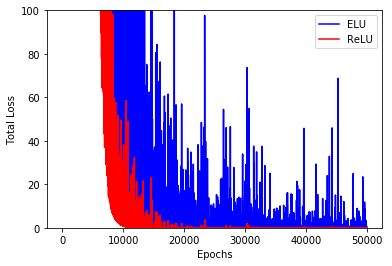

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

fig = plt.figure()
plt.plot(range(1, len(Le)+1), Le, 'b-', label="ELU")
plt.plot(range(1, len(Le)+1), Lre, 'r-', label="ReLU")
plt.ylim([0, 100])
plt.xlabel("Epochs")
plt.ylabel("Total Loss")
plt.legend()

fig

It appears that both losses have plateaued. Where?

In [3]:
print("ELU")
print(Le[-10:])
print("ReLU")
print(Lre[-10:])

ELU
[0.010263959877192974, 0.004237656947225332, 0.006807688623666763, 0.0027841106057167053, 0.008469672873616219, 0.005971670150756836, 0.14984779059886932, 0.0013821371830999851, 0.00044481988879851997, 0.0003595022135414183]
ReLU
[0.01630525477230549, 0.02300523966550827, 0.03049849346280098, 0.032687894999980927, 0.03255479037761688, 0.027528710663318634, 0.017459144815802574, 0.004815218970179558, 0.001433060853742063, 0.006304998882114887]


Great. Now, let's examin the behavior far from the training distribution

## Plots of The Function

In [7]:
# Get data and ground truth

x = np.arange(-10, 10, 0.01)
y = 20*np.arange(-10, 10, 0.01)

In [8]:
# Compute network output

data = torch.FloatTensor(x.reshape(-1, 1)).cuda()

oe = e(data)
ore = re(data)

ye = oe.cpu().detach().numpy()
yre = ore.cpu().detach().numpy()

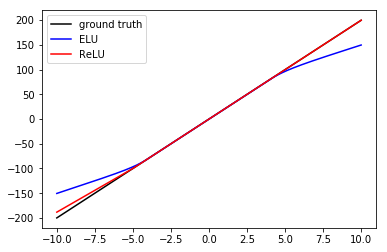

In [9]:
# Plot output

fig = plt.figure()

plt.plot(x, y, 'k-', label="ground truth")
plt.plot(x, ye, 'b-', label="ELU")
plt.plot(x, yre, 'r-', label="ReLU")

plt.legend()

fig

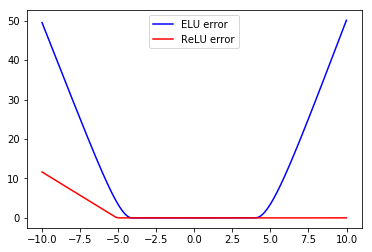

In [10]:
# Plot the L2 error

fig = plt.figure()

plt.plot(x, np.sqrt((ye.reshape(2000)-y)**2), 'b-', label="ELU error")
plt.plot(x, np.sqrt((yre.reshape(2000)-y)**2), 'r-', label="ReLU error")

plt.legend()

fig

Ther seems to be a significant error even here, for both networks, even though ReLU is far closer (about 2 percent).

Let's look at the internals of these networks in order to see where we can expect further errors.

In [11]:
print("ReLU")

print(re.fc1.weight)
print(re.fc1.bias)
print(-re.fc1.bias.view(-1, 1)/re.fc1.weight)

print("\n\n#######################\n\n")

print(re.fc2.weight)
print(re.fc2.bias)

ReLU
Parameter containing:
tensor([[ 1.7428],
        [ 0.6669],
        [ 0.5398],
        [-4.1174],
        [-3.7540],
        [ 2.9985],
        [ 0.4249],
        [ 2.7977]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.5658,  3.3252,  2.7852,  1.3370,  2.9465, -2.3535,  2.1970, -0.9085],
       device='cuda:0', requires_grad=True)
tensor([[ 0.3246],
        [-4.9860],
        [-5.1594],
        [ 0.3247],
        [ 0.7849],
        [ 0.7849],
        [-5.1701],
        [ 0.3247]], device='cuda:0', grad_fn=<DivBackward0>)


#######################


Parameter containing:
tensor([[ 2.0093,  1.5778,  1.5628, -2.2641, -2.2132,  2.7706,  1.1178,  2.0799]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-2.5087], device='cuda:0', requires_grad=True)


Based on $ - b / w$, we see that between $-10$ and $+10$, we should scroll past all the "elbows" of the ReLU functions. What about the ELU?

In [13]:
print("ELU")

print(e.fc1.weight)
print(e.fc1.bias)
print(-e.fc1.bias.view(-1, 1)/e.fc1.weight)

print("\n\n#######################\n\n")

print(e.fc2.weight)
print(e.fc2.bias)

ELU
Parameter containing:
tensor([[ 1.2844],
        [-1.1446],
        [-0.5486],
        [ 1.0157],
        [ 1.2090],
        [-0.8384],
        [-0.7721],
        [-1.1439]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([5.3056, 4.6866, 2.0333, 4.1025, 4.9672, 3.3251, 3.0302, 4.6834],
       device='cuda:0', requires_grad=True)
tensor([[-4.1309],
        [ 4.0944],
        [ 3.7060],
        [-4.0392],
        [-4.1084],
        [ 3.9663],
        [ 3.9245],
        [ 4.0942]], device='cuda:0', grad_fn=<DivBackward0>)


#######################


Parameter containing:
tensor([[ 2.7580, -3.2528, -1.3050,  3.1617,  2.5287, -1.7163, -2.4325, -2.1274]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0.7758], device='cuda:0', requires_grad=True)


ELU too. Let's go to $1000$, to appreciate the behavior at the asymptotes.

In [15]:
# Get data and ground truth

x = np.arange(-1000, 1000, 1.)
y = 20*np.arange(-1000, 1000, 1.)

In [16]:
# Compute network output

data = torch.FloatTensor(x.reshape(-1, 1)).cuda()

oe = e(data)
ore = re(data)

ye = oe.cpu().detach().numpy()
yre = ore.cpu().detach().numpy()

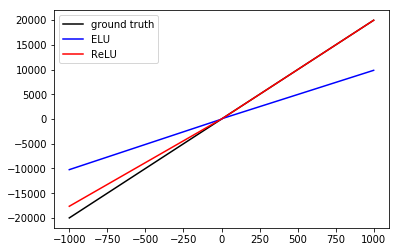

In [17]:
# Plot output

fig = plt.figure()

plt.plot(x, y, 'k-', label="ground truth")
plt.plot(x, ye, 'b-', label="ELU")
plt.plot(x, yre, 'r-', label="ReLU")

plt.legend()

fig

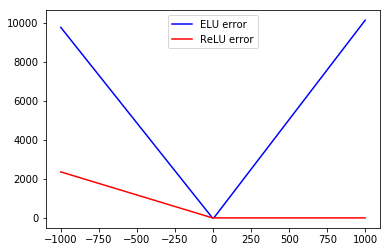

In [18]:
# Plot the L2 error

fig = plt.figure()

plt.plot(x, np.sqrt((ye.reshape(2000)-y)**2), 'b-', label="ELU error")
plt.plot(x, np.sqrt((yre.reshape(2000)-y)**2), 'r-', label="ReLU error")

plt.legend()

fig

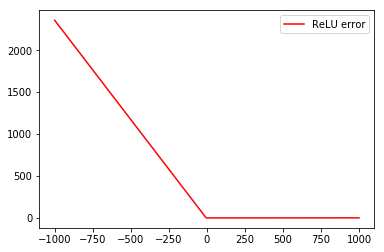

In [19]:
# Focus only on ReLU

fig = plt.figure()

plt.plot(x, np.sqrt((yre.reshape(2000)-y)**2), 'r-', label="ReLU error")

plt.legend()

fig

/nfs01/shared_software/anaconda3/envs/artem/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


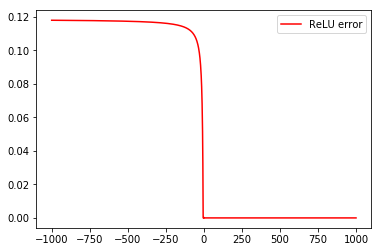

In [20]:
# Focus only on ReLU

fig = plt.figure()

plt.plot(x, np.sqrt((yre.reshape(2000)-y)**2)/abs(y), 'r-', label="ReLU error")

plt.legend()

fig

/nfs01/shared_software/anaconda3/envs/artem/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


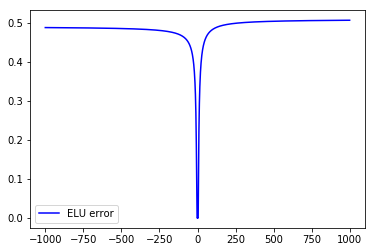

In [21]:
# Focus only on ELU

fig = plt.figure()

plt.plot(x, np.sqrt((ye.reshape(2000)-y)**2)/abs(y), 'b-', label="ELU error")

plt.legend()

fig

## Concluding Thoughts

The error in this, harder case seems to be closer to 12 percent (50 for the ELU network), even though this function is still well within-domain.